In [6]:
pip install tensorflow.io


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 10.8 MB/s eta 0:00:00


In [7]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np

In [8]:
wale = os.path.join('data', '5601601O.wav')
not_wale = os.path.join('data', '81015005.wav')
test = os.path.join('data', 'Eubalaena_glacialis', '5601700F.wav')

In [9]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [15]:
EG = os.path.join('data', 'Eubalaena_glacialis')
PY = os.path.join('data', 'Rosmarus')

In [17]:
eg_dt = tf.data.Dataset.list_files(EG+'/*.wav')
py_dt = tf.data.Dataset.list_files(PY+'/*.wav')

In [18]:
eu_gl = tf.data.Dataset.zip((eg_dt, tf.data.Dataset.from_tensor_slices(tf.ones(len(eg_dt)))))
py_gl = tf.data.Dataset.zip((py_dt, tf.data.Dataset.from_tensor_slices(tf.ones(len(py_dt)))))

In [19]:
data = eu_gl.concatenate(py_gl)

lengths = []
for file in os.listdir(os.path.join('data', 'Eubalaena_glacialis')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Eubalaena_glacialis', file))
    lengths.append(len(tensor_wave))

In [21]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=35235>

In [22]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=9493>

In [23]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=73085>

In [24]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:32000]
    zero_padding = tf.zeros([32000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [25]:
filepath, label = eu_gl.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [26]:
spectrogram, label = preprocess(filepath, label)

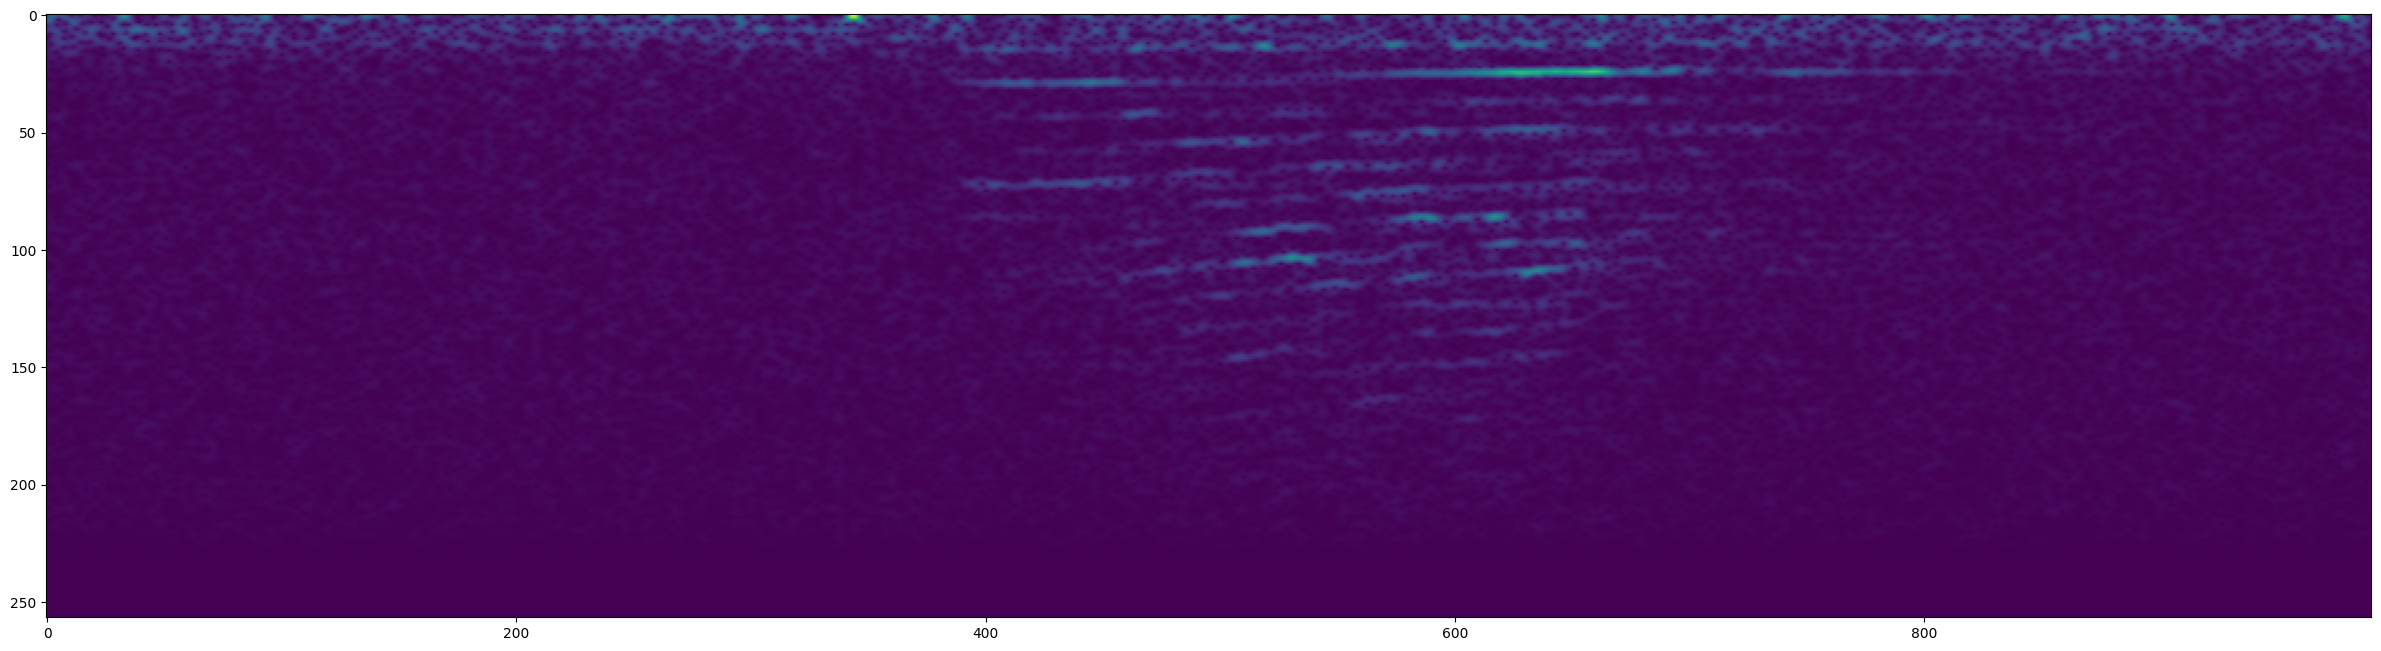

In [27]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [28]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [29]:
len(data)*.7

4.199999999999999

In [31]:
train = data.take(4)
test = data.skip(4).take(3)

In [32]:
samples, labels = train.as_numpy_iterator().next()

In [33]:
samples.shape

(16, 991, 257, 1)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [35]:
model = Sequential()
model.add(Conv2D(8, (2,2), activation='relu', input_shape=(991, 257, 1)))
model.add(Conv2D(8, (2,2), activation='relu'))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 990, 256, 8)       40        
                                                                 
 conv2d_3 (Conv2D)           (None, 989, 255, 8)       264       
                                                                 
 flatten_1 (Flatten)         (None, 2017560)           0         
                                                                 
 dense_2 (Dense)             (None, 8)                 16140488  
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 16140801 (61.57 MB)
Trainable params: 16140801 (61.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
4/4 [==============================] - 12s 3s/step - loss: 0.2172 - recall: 0.8438 - precision: 1.0000 - val_loss: 2.1916e-24 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/4
4/4 [==============================] - 8s 2s/step - loss: 1.4576e-31 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.3050e-33 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/4
4/4 [==============================] - 9s 2s/step - loss: 0.0000e+00 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
4/4 [==============================] - 9s 2s/step - loss: 0.0000e+00 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000 - val_precision: 1.0000


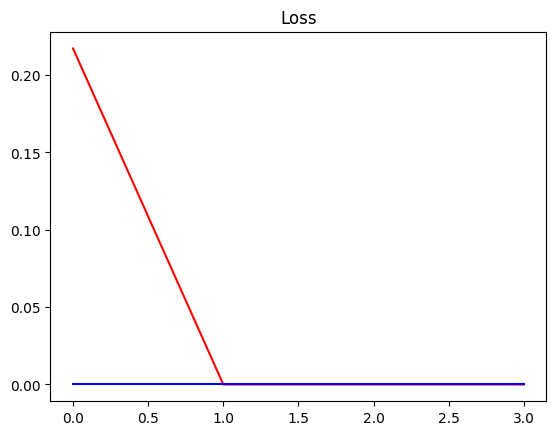

In [39]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [40]:
print(hist.history)

{'loss': [0.21717175841331482, 1.4576474370041156e-31, 0.0, 0.0], 'recall': [0.84375, 1.0, 1.0, 1.0], 'precision': [1.0, 1.0, 1.0, 1.0], 'val_loss': [2.191640385371019e-24, 1.304968349574143e-33, 0.0, 0.0], 'val_recall': [1.0, 1.0, 1.0, 1.0], 'val_precision': [1.0, 1.0, 1.0, 1.0]}


In [42]:
print(hist.history['precision'])

[1.0, 1.0, 1.0, 1.0]


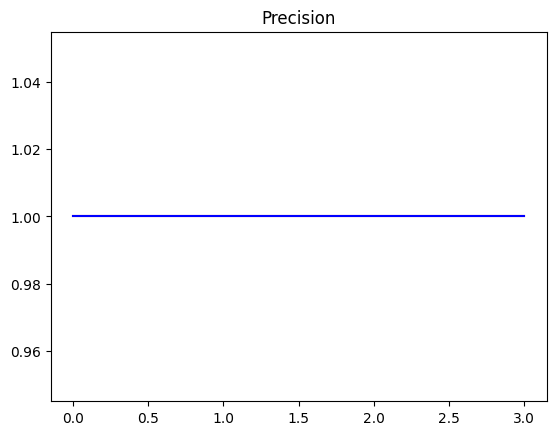

In [41]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

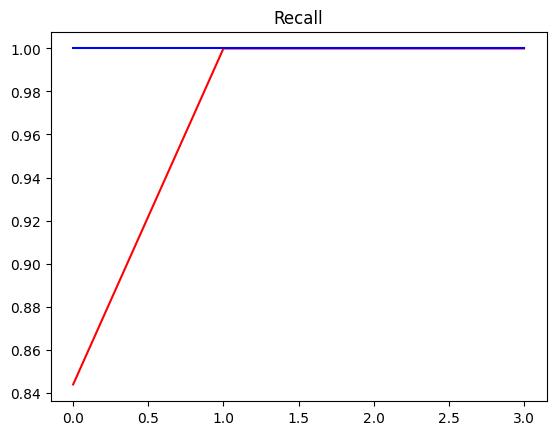

In [44]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [45]:
X_test, y_test = test.as_numpy_iterator().next()

In [46]:
yhat = model.predict(X_test)

1/1 [==============================] - 1s 1s/step
